In [1]:
import numpy as np
import matplotlib.pyplot as plt
import noisereduce as nr
import scipy
from scipy.io import wavfile
from scipy.stats import norm
from sklearn.cluster import KMeans

In [2]:
def Convergence(Error1,Error2,times,epsilon):
    if np.abs(Error1-Error2)<epsilon:
        times=times+1
    else:
        times=0
    if times==5:
        return True,times
    else:
        return False,times

In [3]:
#Proposed Scheme 
def NoiseReduceExtented(signal,samplerate,vis=False):

    S=np.zeros(np.shape(signal))
    Errors=np.array([])
    counter=0
    Step=0
    inp=signal-S
    Stop=False
    
    while(Stop==False):
        denoise=nr.reduce_noise(y=inp, sr=samplerate)
        S=S+denoise #clean
        inp=signal-S #noise
        
        (mu, sigma) = norm.fit(inp)
    
        if vis==True:
            distr, bins, patches = plt.hist(inp, 300, facecolor='green',density =True,stacked =True)
            gaussian = scipy.stats.norm.pdf( bins, mu, sigma)
            plt.plot(bins, gaussian, 'r--', linewidth=2)
            plt.show()
        else:
            distr, bins= np.histogram(inp, 300,density =True)
            
        gaussian = scipy.stats.norm.pdf( bins, mu, sigma)
        
        if Step>0:
            MSE=np.mean((gaussian[:-1]-distr)**2)
            Errors=np.append(Errors,MSE)

        if Step>1:   
            Stop,counter=Convergence(Errors[Step-2],Errors[Step-1],counter,1e-4)
            
        #Safety        
        if Step>300:
            Stop=True 
        Step=Step+1
    Signal_opt=S
    return Signal_opt,Step

In [4]:
def find_noise(Segments):
    #small energy=noisy segments
    Energies=np.log(np.sum(Segments**2,axis=1)).reshape(-1,1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Energies)
    labels=kmeans.predict(Energies, sample_weight=None)
    c1=Segments[np.where(labels==0)]
    c2=Segments[np.where(labels==1)]
    if np.mean(Energies[np.where(labels==0)],axis=0)<np.mean(Energies[np.where(labels==1)]):
        Small_energy=c1
    else:
        Small_energy=c2
    
    Noise=Small_energy[np.where(Small_energy.std(axis=1)<=np.mean(Small_energy.std(axis=1)))]
    if Noise.shape[0]>0:
        return Noise
    else:
        return Small_energy
    

In [5]:
def noise_reduce(sig,sampling_rate,alpha,beta=0.01,time_ms=30,time_s=None):

    if time_s==None:
        time_s=9999
    block_size=int((time_ms*(10**(-3)))*sr)
    j=int((np.floor(sig.shape[0]/block_size)))
    
    Segmented_signal=sig[:j*block_size].reshape(-1,block_size)
    
    if (np.floor(sig.shape[0]%block_size))!=0:
        Lost_signal=sig[j*block_size:]
        last_segment=np.zeros(block_size)
        last_segment[:Lost_signal.shape[0]]=Lost_signal
        last_segment=last_segment.reshape(1,-1)
        Segmented_signal=np.concatenate([Segmented_signal,last_segment],axis=0)
        
    #Find noise
    subsignal=sig[:time_s*sampling_rate]
    
    k=int((np.floor(subsignal.shape[0]/block_size)))
    
    Segmented_subsignal=subsignal[:k*block_size].reshape(-1,block_size)
    
    noise=find_noise(Segmented_subsignal)
    noise_model=np.mean(np.abs(scipy.fft.fft(noise)),axis=0)
    
    y_fft=(scipy.fft.fft(Segmented_signal))
    Y_mag=(np.abs(y_fft))
    Y_angle=np.angle(y_fft)
    X_mag=Y_mag-alpha*noise_model
    #applying T
    if alpha!=1:
        X_mag[np.where(X_mag<beta*Y_mag)]=beta*Y_mag[np.where(X_mag<beta*Y_mag)]
    X=X_mag*np.exp(1.0j*Y_angle)
    x=scipy.fft.ifft(X).real.astype(np.float32)
    x=x.reshape(-1)[:sig.shape[0]]
    return x

In [ ]:
#Spectral Subtraction
for i in range(1,3000):
    
    for j in ['Patra','Nikaia']:
        try:
            sr, mixtureR = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_R_scaled')
            sr, mixtureL = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_L_scaled')
            s_R=noise_reduce(mixtureR,sr,1,beta=0.01,time_ms=1)
            s_L=noise_reduce(mixtureL,sr,1,beta=0.01,time_ms=1)
            
            wavfile.write(str(i)+'_R_denoised', sr, s_R)
            wavfile.write(str(i)+'_L_denoised', sr, s_L)
            print(i)
        except:
            continue

In [ ]:
#SpectralSubtraction
for i in range(1000,3000):
    
    for j in ['Patra','Nikaia']:
        try:
            sr, mixtureR = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_R_scaled')
            sr, mixtureL = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_L_scaled')
            sr,s_R=wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_dn/'+str(i)+'_R_denoised')
            sr,s_L=wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_dn/'+str(i)+'_L_denoised')
            plt.title(str(i))
            plt.plot(mixtureR)
            plt.plot(s_R)
            #plt.plot(s_R-mixtureR)
            #plt.title(str(i))
            #plt.hist(mixtureR-s_R,300)
            plt.show()
            #plt.plot(mixtureL)
            #plt.plot(s_L)
            #plt.plot(s_L-mixtureL)
            #plt.hist(mixtureL-s_L,300)
            plt.show()
            
        except:
            continue

# Experiments

In [6]:
#Experiments with extented spectral gating

j='Patra'
i=43

sr, mixtureR1 = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_R_scaled')
sr, mixtureL1 = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_L_scaled')
s_R1=noise_reduce(mixtureR1,sr,1,beta=0.01,time_ms=1)
s_L1=noise_reduce(mixtureL1,sr,1,beta=0.01,time_ms=1)


wavfile.write(str(i)+'_R_denoised', sr, s_R1)
wavfile.write(str(i)+'_L_denoised', sr, s_L1)
wavfile.write(str(i)+'_L_noise', sr, mixtureL1-s_L1)
wavfile.write(str(i)+'_R_noise', sr, mixtureR1-s_R1)

In [7]:
j='Nikaia'
i=2457

sr, mixtureR2 = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_R_scaled')
sr, mixtureL2 = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_L_scaled')
s_R2=noise_reduce(mixtureR2,sr,1,beta=0.01,time_ms=1)
s_L2=noise_reduce(mixtureL2,sr,1,beta=0.01,time_ms=1)


wavfile.write(str(i)+'_R_denoised', sr, s_R2)
wavfile.write(str(i)+'_L_denoised', sr, s_L2)
wavfile.write(str(i)+'_L_noise', sr, mixtureL2-s_L2)
wavfile.write(str(i)+'_R_noise', sr, mixtureR2-s_R2)

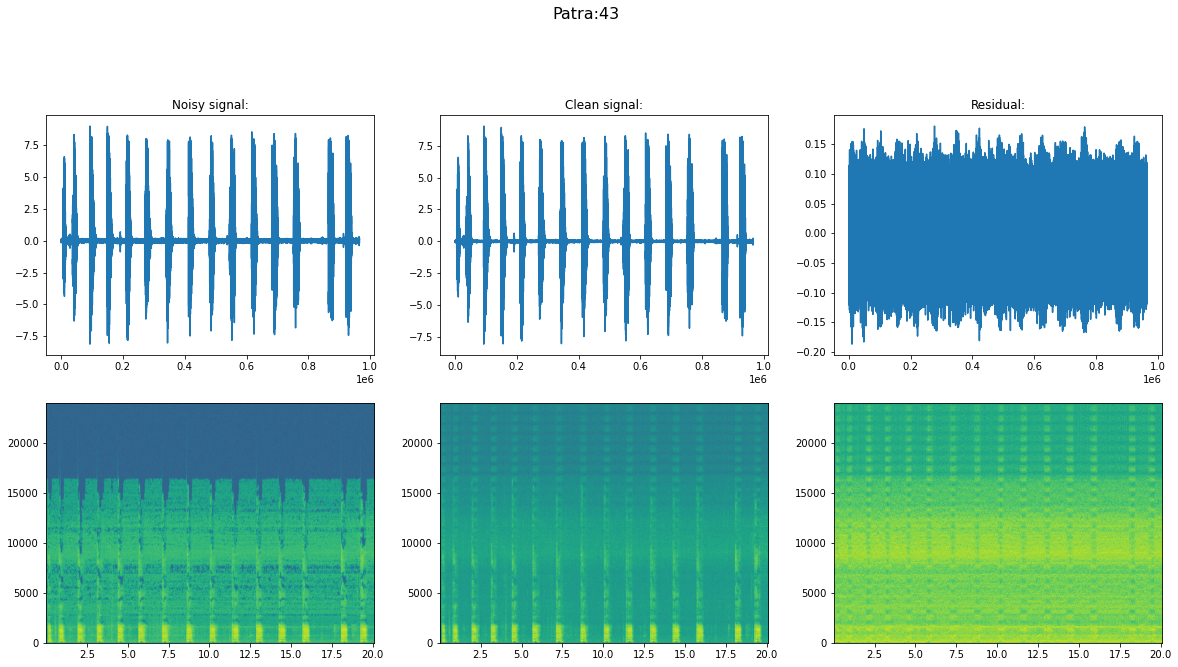

In [8]:
#visualization of  extented spectral denoising
data=mixtureL1
out=s_L1
name='Patra:43'

gridsize = (3, 3)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(name,fontsize=16)
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))

ax4 = plt.subplot2grid(gridsize, (1, 0))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 2))


ax1.set_title('Noisy signal:')
ax1.plot(data)
ax2.set_title('Clean signal:')
ax2.plot(out)
ax3.set_title('Residual:')
ax3.plot((data-out))


ax4.specgram(data,NFFT=1024,Fs=48000,noverlap=512)
ax5.specgram(out,NFFT=1024,Fs=48000,noverlap=512)
ax6.specgram(data-out,NFFT=1024,Fs=48000,noverlap=512)
plt.show()

/home/myron/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


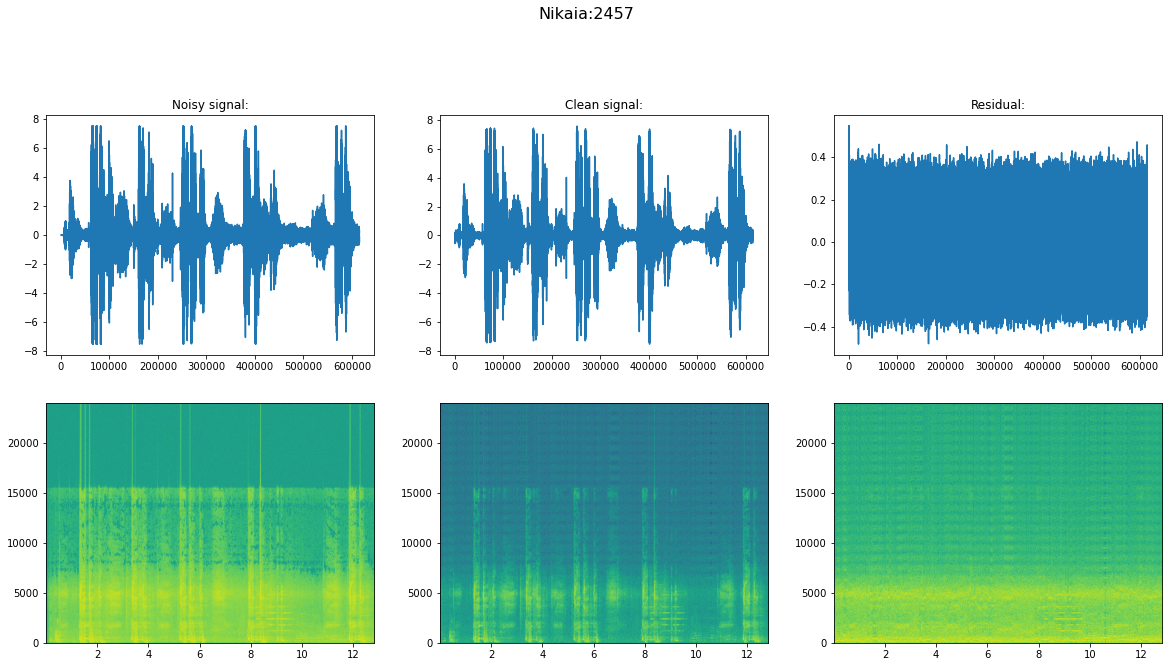

In [9]:
data=mixtureL2
out=s_L2
name='Nikaia:2457'

gridsize = (3, 3)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(name,fontsize=16)
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))

ax4 = plt.subplot2grid(gridsize, (1, 0))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 2))


ax1.set_title('Noisy signal:')
ax1.plot(data)
ax2.set_title('Clean signal:')
ax2.plot(out)
ax3.set_title('Residual:')
ax3.plot((data-out))


ax4.specgram(data,NFFT=1024,Fs=48000,noverlap=512)
ax5.specgram(out,NFFT=1024,Fs=48000,noverlap=512)
ax6.specgram(data-out,NFFT=1024,Fs=48000,noverlap=512)
plt.show()

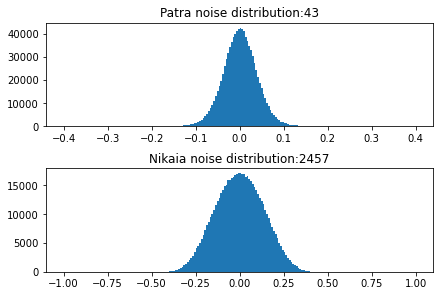

In [59]:
#Noise distribution
noisePatra=mixtureL1-s_L1
noiseNikaia=mixtureL2-s_L2

fig, (ax5,ax6)= plt.subplots(2,1,constrained_layout = True)


ax5.title.set_text('Patra noise distribution:'+str(43))
ax6.title.set_text('Nikaia noise distribution:'+str(2457))


ax5.hist( noisePatra,bins=200,range=[-.4,.4])

ax6.hist( noiseNikaia,bins=200,range=[-1,1])
plt.show()

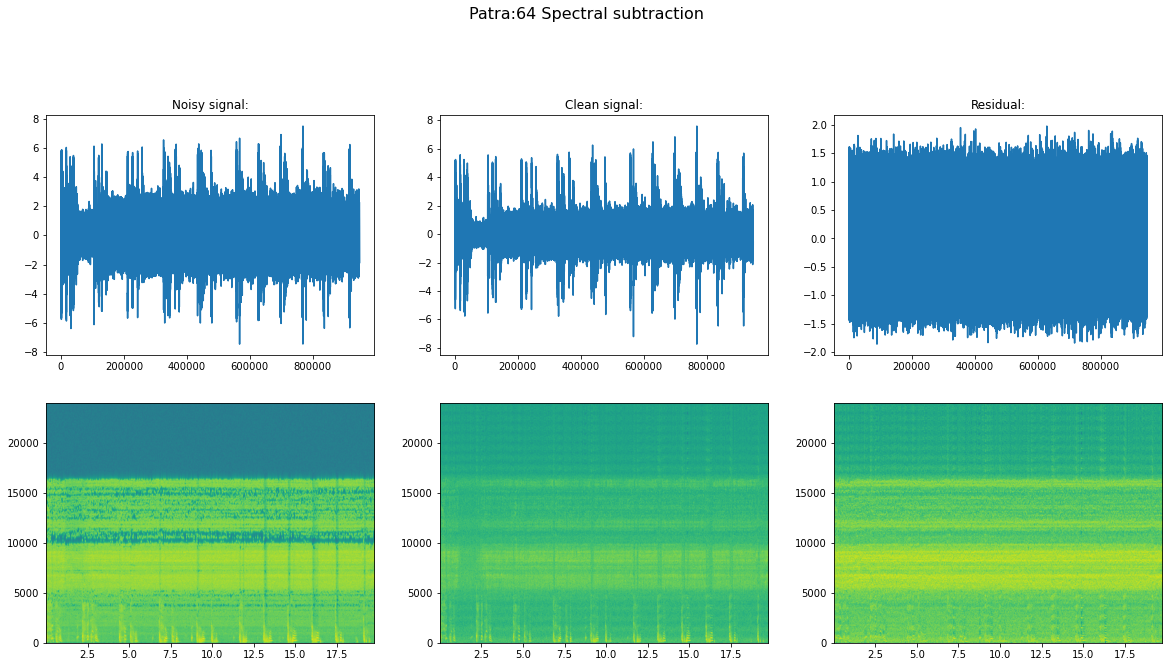

In [11]:
#Signals with powerfull noise.
j='Patra'
i=64


sr, mixtureR3 = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_R_scaled')
sr, mixtureL3 = wavfile.read('/home/myron/Desktop/Diplomatikh/data/F_Covid19/'+j+'_LR_st/'+str(i)+'_L_scaled')



s_R3=noise_reduce(mixtureR3,sr,1,beta=0.01,time_ms=1)
s_L3=noise_reduce(mixtureL3,sr,1,beta=0.01,time_ms=1)

#visualization of denoising
#------------------------------------------------------------------------
data=mixtureL3
out=s_L3
name='Patra:64 Spectral subtraction'

gridsize = (3, 3)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(name,fontsize=16)
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))

ax4 = plt.subplot2grid(gridsize, (1, 0))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 2))


ax1.set_title('Noisy signal:')
ax1.plot(data)
ax2.set_title('Clean signal:')
ax2.plot(out)
ax3.set_title('Residual:')
ax3.plot((data-out))


ax4.specgram(data,NFFT=1024,Fs=48000,noverlap=512)
ax5.specgram(out,NFFT=1024,Fs=48000,noverlap=512)
ax6.specgram(data-out,NFFT=1024,Fs=48000,noverlap=512)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

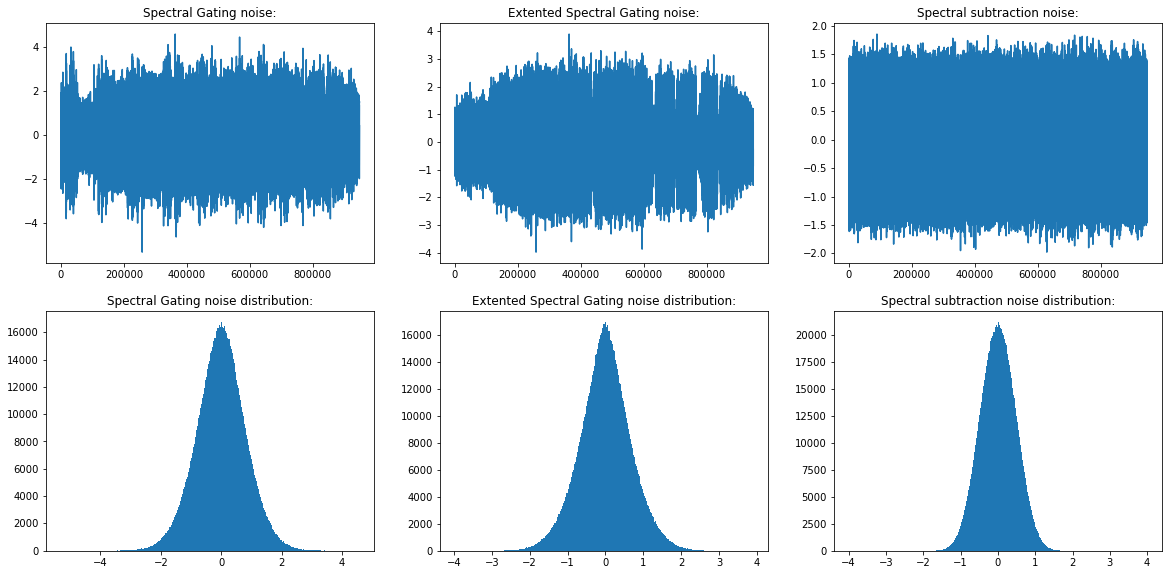

In [12]:
#Noise distributions
s_R4,_=NoiseReduceExtented(mixtureR3,sr)
s_L4,_=NoiseReduceExtented(mixtureL3,sr)


s_R5=nr.reduce_noise(mixtureR3,sr)
s_L5=nr.reduce_noise(mixtureL3,sr)


gridsize = (3, 3)
fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))

ax4 = plt.subplot2grid(gridsize, (1, 0))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 2))


ax1.set_title('Spectral Gating noise:')
ax1.plot((s_L5-mixtureL3))

ax2.set_title('Extented Spectral Gating noise:')
ax2.plot((s_L4-mixtureL3))

ax3.set_title('Spectral subtraction noise:')
ax3.plot((s_L3-mixtureL3))

ax4.set_title('Spectral Gating noise distribution:')
ax4.hist((s_L5-mixtureL3),300)

ax5.set_title('Extented Spectral Gating noise distribution:')
ax5.hist((s_L4-mixtureL3),300)

ax6.set_title('Spectral subtraction noise distribution:')
ax6.hist((s_L3-mixtureL3),300)
plt.show()

In [ ]:
wavfile.write(str(i)+'_R_denoised', sr, s_R3)
wavfile.write(str(i)+'_L_denoised', sr, s_L3)
wavfile.write(str(i)+'_L_noise', sr, mixtureL3-s_L3)
wavfile.write(str(i)+'_R_noise', sr, mixtureR3-s_R3)